# Rubik's Cube Solver

## Dependencies

In [1]:
import cv2
import imutils
import pathlib
import numpy as np
from imutils import contours
from imutils import perspective
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (12, 12)

## Loading a sample

In [98]:
def load_image(path: pathlib.Path, verbose: bool = False) -> np.ndarray:
    img = cv2.imread(path)
    # resize
    img = imutils.resize(img, width=480)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y = img[:, :, 0]
    cr = img[:, :, 1]
    cb = img[:, :, 2]
    y = cv2.equalizeHist(y)
    img = cv2.merge((y, cr, cb))
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    if verbose:
        plt.figure()
        plt.imshow(img)
    return img

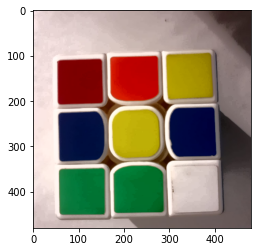

In [222]:
rgb_sample = load_image("data/3.png", verbose=True)
sample = cv2.cvtColor(rgb_sample, cv2.COLOR_RGB2HSV)

h = sample[:, :, 0]
s = sample[:, :, 1]
v = sample[:, :, 2]

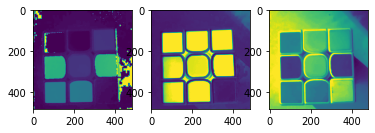

In [223]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(h)

plt.subplot(1, 3, 2)
plt.imshow(s)

plt.subplot(1, 3, 3)
plt.imshow(v)

In [225]:
def find_cube(hsv_img):
    s = hsv_img[:, :, 1]
    s_bin = process_channel(s)
    cnts = cv2.findContours(s_bin,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    x_min = np.inf
    y_min = np.inf
    x_max = -np.inf
    y_max = -np.inf
    for c in cnts:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        x_left = np.min(box[:, 0])
        x_right = np.max(box[:, 0])
        y_top = np.min(box[:, 1])
        y_bottom = np.max(box[:, 1])
        if x_left < x_min:
            x_min = x_left
        if y_top < y_min:
            y_min = y_top
        if x_right > x_max:
            x_max = x_right
        if y_bottom > y_max:
            y_max = y_bottom
    return perspective.four_point_transform(hsv_img, np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]))

In [228]:
def apply_morphs(xs):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    xs = cv2.morphologyEx(xs, cv2.MORPH_OPEN, kernel, iterations=8)
    # bg = cv2.dilate(xs, kernel, iterations=8)
    dst = cv2.distanceTransform(xs, cv2.DIST_L2, 5)
    _, fg = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    fg = np.uint8(fg)
    return fg

In [224]:
def process_channel(channel: np.ndarray) -> np.ndarray:
    _, channel = cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    channel = apply_morphs(channel)
    return channel

In [231]:
def get_color_mask(hsv_img: np.ndarray) -> np.ndarray:
    s = hsv_img[:, :, 1]
    fg = process_channel(s)
    inv_fg = process_channel(cv2.bitwise_not(s))
    return cv2.bitwise_or(fg, inv_fg)

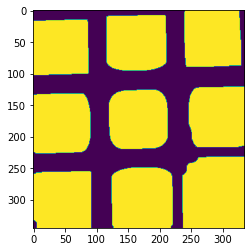

In [239]:
warped = find_cube(sample)
rgb_warped = cv2.cvtColor(warped, cv2.COLOR_HSV2RGB)
color_mask = get_color_mask(warped)

plt.figure()
plt.imshow(color_mask)

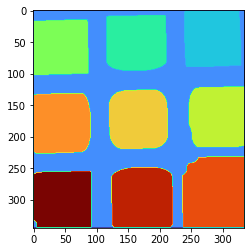

In [246]:
n, markers = cv2.connectedComponents(color_mask)
markers = markers + 1
markers = cv2.watershed(rgb_warped, markers)
rgb_warped[markers == -1] = [255, 0, 0]
plt.imshow(markers, cmap="turbo")